In [1]:
## From: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

#import get to call a get request on the site
from requests import get

#get the first page of the housing prices
response = get('https://minneapolis.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print( len(posts)) #to double check I got 120 (elements/page)
post = posts[0]

<class 'bs4.element.ResultSet'>
120


In [2]:
curtime = post.find('time',class_='result-date')['datetime']
print(curtime)
cururl = post.find('a',class_='result-title hdrlnk')['href']
print(cururl)

2020-07-29 14:32
https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-spacious-and-beautiful/7168162226.html


In [3]:
#curbrs = post.find('span', class_ = 'housing').text.split()[0][:-2]
#print(curbrs)

#cursqft = post.find('span', class_ = 'housing')
#if cursqft:
#    cursqft = cursqft.text.split()[2][:-3] #cleans the ft2 at the end
#    print(cursqft)
#print(cursqft)

curhood = post.find('span', class_='result-hood') 
if curhood:
    curhood = curhood.text
    print(curhood)



 (Plymouth)


In [4]:
from geopy.geocoders import Nominatim, ArcGIS
#curmap = BeautifulSoup(get(cururl).text,'html.parser').find_all('div',class_='mapbox')[0]
#geolocator = Nominatim(user_agent="darren")
#
#print(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
#
#location = geolocator.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
#
#
#geolocator2 = ArcGIS(user_agent="darren")
#location2 = geolocator2.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'],
#                                distance=500)
#
#
#
#
#
import numpy as np

#loc = geolocator.reverse(query=str(np.round(float(curmap.find('div')['data-latitude'])-.001,3))
#                   +","
#                   +str(np.round(float(curmap.find('div')['data-longitude'])-.001,3)))
#    
#print(location.address)
#print(location2.address)
#print(loc.address)

#print(location.raw['address'])
#print(location.raw['address']['city'])
#print(location.raw['address']['neighbourhood'])
#print(location.raw['address']['postcode'])

In [5]:
#location

In [6]:
#curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
#curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
#print(curmap)

In [7]:
#new code to put here:
#get list of neighborhoods
#for each neighborhood,
#  get central coordinate
#for each posting
#  calculate distance from neighborhoods' centers
#  assign neighborhood based on nearest neighbor

In [8]:
#linkpfx = 'https://minneapolis.craigslist.org/search/apa?'
#linksfx =( 'sort=date'
#          +'&hasPic=1'
#          +'&bundleDuplicates=1'
#          +'&search_distance=20'
#          +'&postal=55454'
#          +'&min_price=500'
#          +'&max_price=4000'
#          +'&max_bedrooms=3'
#          +'&availabilityMode=0'
#          +'&sale_date=all+dates')
#response = get(linkpfx+linksfx)
#html_soup = BeautifulSoup(response.text, 'html.parser')
#results_num = html_soup.find('div', class_= 'search-legend')
#results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
#pages = np.arange(0, results_total+1, 120)
#print(results_total)
#print(pages)

#post.find('a', class_='result-title hdrlnk')['href'] in post_links
#post.find('a', class_='result-title hdrlnk')['href'] in 
#apts['URL'].str.contains(post.find('a', class_='result-title hdrlnk')['href']).sum()
#apts['URL'].str.contains('https://minneapolis.craigslist.org/dak/apa/d/burnsville-end-unit-2-bedroom-townhouse/7135839874.html').sum()

In [9]:
#build out the loop
from bs4 import BeautifulSoup
from time import sleep, time
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from IPython.core.display import clear_output
import numpy as np

import requests


citystr = 'minneapolis' ## 'washingtondc' #'minneapolis'
linkpfx = 'https://'+citystr+'.craigslist.org/search/apa?'
linksfx =( 'sort=date'
          +'&hasPic=1'
          +'&bundleDuplicates=1'
          +'&search_distance=7'
          +'&postal=55454' #MPLS: 55454 #DC: 20009
          +'&min_price=300'
          +'&max_price=8000'
          +'&max_bedrooms=4'
          +'&availabilityMode=0'
          +'&sale_date=all+dates')
response = get(linkpfx+linksfx)
html_soup = BeautifulSoup(response.text, 'html.parser')
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
pages = np.arange(0, results_total+1, 120)


from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="derinkuyu",timeout=5)

#
TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street parking':5,
    'valet parking':6,
    'no parking':7
}

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []


cities = []
towns = []
neighborhoods = []
zips = []


types = []
laundries = []
parkings = []

for page in pages:
    
    #get request
    response = get(linkpfx
                   + 's=' #parameter for defining page number
                   + str(page) #page in above array
                   + linksfx)    
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:
        
        curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
        curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
        
        if (post.find('span', class_ = 'result-hood') is not None) and curmap and (
        post.find('a', class_='result-title hdrlnk')['href'] not in post_links):

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #
            #curpost = get(post_link).text
            curmap = curmap[0] #BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')[0]
            location = geolocator.reverse(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
            
            try: 
                cities.append(location.raw['address']['city'])
            except:
                try: 
                    cities.append(location.raw['address']['town'])
                except:
                    cities.append('')
            
            try: 
                towns.append(location.raw['address']['town'])
            except:
                towns.append('')
            
            try:
                neighborhoods.append(location.raw['address']['neighbourhood'])
            except:
                try: 
                    locshift1 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    neighborhoods.append(locshift1.raw['address']['neighbourhood'])
                except:                   
                    try: 
                        locshift2 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                        neighborhoods.append(locshift2.raw['address']['neighbourhood'])
                    except:
                        try:
                            neighborhoods.append(location.raw['address']['town'])
                        except:
                            try:
                                neighborhoods.append(location.raw['address']['city'])
                            except:
                                neighborhoods.append('')
            
            try:
                zips.append(location.raw['address']['postcode'])
            except:
                zips.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                typename = list(set(curattr.text.split('\n')).intersection(list(TypeDict.keys())))[0]
                types.append(TypeDict[typename])
            except:
                types.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                laundryname = list(set(curattr.text.split('\n')).intersection(list(LaundryDict.keys())))[0]
                laundries.append(LaundryDict[laundryname])
            except:
                laundries.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                parkname = list(set(curattr.text.split('\n')).intersection(list(ParkingDict.keys())))[0]
                parkings.append(ParkingDict[parkname])
            except:
                parkings.append('')
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

import pandas as pd

apts = pd.DataFrame({
    'posted': post_timing,
    'neighborhood': post_hoods,
    'post title': post_title_texts,
    'number bedrooms': bedroom_counts,
    'sqft': sqfts,
    'URL': post_links,
    'price': post_prices,
    'cities':cities,
    'towns':towns,
    'neighborhoods':neighborhoods,
    'zips': zips,
    'types':types,
    'parking':parkings,
    'laundry':laundries})
#print(apts.info())
#apts.head(30)
apts.shape

#drop duplicates
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])

#make the number bedrooms to a float (since np.nan is a float too)
apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

apts.to_csv(path_or_buf='./scraped_data/apts_'+citystr+"_"+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
apts.shape


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


(109, 14)

In [10]:
##drop duplicates
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
#
##make the number bedrooms to a float (since np.nan is a float too)
#apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))
#
##convert datetime string into datetime object to be able to work with it
#from datetime import datetime
#
#apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

#apts.to_csv(path_or_buf='./apts_'+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
#apts.shape

In [11]:
import os
import glob
citystr = 'minneapolis' #'minneapolis', 'washingtondc'

aptfiles = glob.glob('./scraped_data/apts_'+citystr+'*')


try:
    del apts
except:
    print('no apts in memory, loading some...')


for file in aptfiles:
    try: 
        apts = apts.append(pd.read_csv(file),ignore_index=True)
    except:
        apts = pd.read_csv(file)
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
apts = apts.drop_duplicates(subset=['price','sqft','number bedrooms','laundry','parking','zips','types','neighborhoods'])
apts = apts[apts['sqft']>400]
apts = apts[apts['sqft']<2000]
apts = apts[apts['price']>559]
apts = apts[apts['price']<2500]
apts = apts[apts['price'] / apts['number bedrooms'] > 400]

print(str(apts.shape[0])+' unique listings considered.')

4621 unique listings considered.


In [12]:
from operator import itemgetter
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)
apt = apts.iloc[0]
zipcode = search.by_zipcode(str(apt['zips']))
zipDict = zipcode.to_dict()
NaN = np.nan
if 'medianIncome' not in apts.columns:
    apts['medianIncome'] = NaN
    apts = pd.concat([apts,pd.DataFrame(columns=list(map(itemgetter('x'), zipDict['population_by_age'][2]['values'])))])
    apts['medianHomeValue'] = NaN
    apts['postdateint'] = NaN
    

print(apts.columns)

Index(['posted', 'neighborhood', 'post title', 'number bedrooms', 'sqft',
       'URL', 'price', 'cities', 'towns', 'neighborhoods', 'zips', 'types',
       'parking', 'laundry', 'medianIncome', 'Under 5', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 Plus',
       'medianHomeValue', 'postdateint'],
      dtype='object')


In [13]:
apt = apts.iloc[0]
np.int(apt['posted'].split('-')[0]+apt['posted'].split('-')[1]+apt['posted'].split('-')[2].split(' ')[0])
#apt['posted'].split('-')[0]+apt['posted'].split('-')[1]+apt['posted'].split('-')[2].split(' ')[0]
#int(apt['posted'].split('-')[0]+
#    apt['posted'].split('-')[1]+
#    apt['posted'].split('-')[2].split(' ')[0]) 

20200604

In [14]:

#index = 0
#apt = apts.iloc[index]
#zipcode = search.by_zipcode(str(apt['zips']))
#zipDict = zipcode.to_dict()
#income = np.float(zipDict['median_household_income'])
#popsByAge = np.array(list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] )) ) / zipDict['population']
#
#apts.loc[index,'medianIncome'] = income
#apts.loc[index,list(map(itemgetter('x'), zipDict['population_by_age'][2]['values']))] = popsByAge
#print(apts.iloc[0])
#
    

    
for index, apt in apts.iterrows():
    zipcode = search.by_zipcode(str(apt['zips']))
    zipDict = zipcode.to_dict()
    income = zipDict['median_household_income']
    if income is not None:
        apts.loc[index,'medianIncome'] = np.float(income)
        
    homeValue = zipDict['median_home_value']
    if homeValue is not None:
        apts.loc[index,'medianHomeValue'] = np.float(income)
        
    if zipDict['population_by_age'] is not None:
        popsByAge = list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] ))
        apts.loc[index,list(map(itemgetter('x'), zipDict['population_by_age'][2]['values']))] = np.array(popsByAge) / zipDict['population']
    
    apts.loc[index,'postdateint'] = np.int(apt['posted'].split('-')[0]+apt['posted'].split('-')[1]+apt['posted'].split('-')[2].split(' ')[0])
    
apts['pYouths'] = apts[['Under 5', '5-9', '10-14','15-19']].sum(axis=1)
apts['pTwenties'] = apts[['20-24','25-29']].sum(axis=1)
apts['pThirties'] = apts[['30-34','35-39']].sum(axis=1)
apts['pForties'] = apts[['40-44','45-49']].sum(axis=1)
apts['pFifties'] = apts[['50-54','55-59']].sum(axis=1)
apts['pSixtyPlus'] = apts[['60-64','65-69','70-74','75-79','80-84','85 Plus']].sum(axis=1)

In [15]:
search = SearchEngine(simple_zipcode=False)
apt = apts.iloc[0]
zipcode = search.by_zipcode(str(apt['zips']))
zipDict = zipcode.to_dict()
zipDict['population']

44356

In [16]:
#from walkscore import WalkScoreAPI
#api_key = 'YOUR API KEY GOES HERE'
#
#walkscore_api = WalkScoreAPI(api_key = api_key)

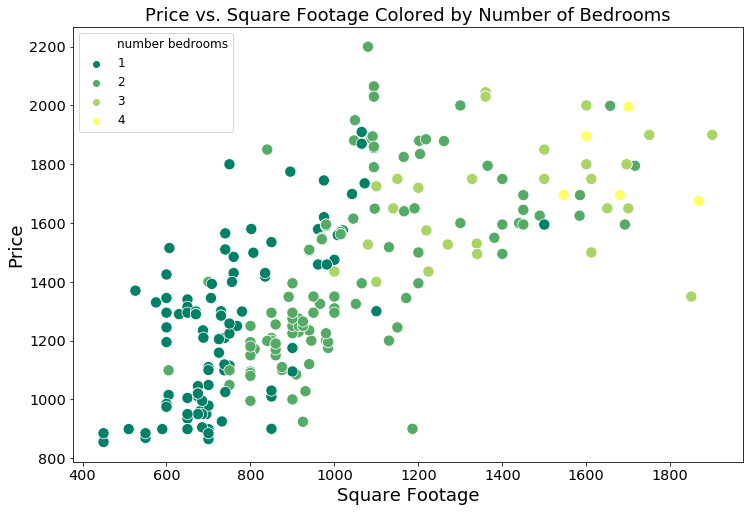

In [17]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sqft', y='price', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=18)
plt.ylabel("Price", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


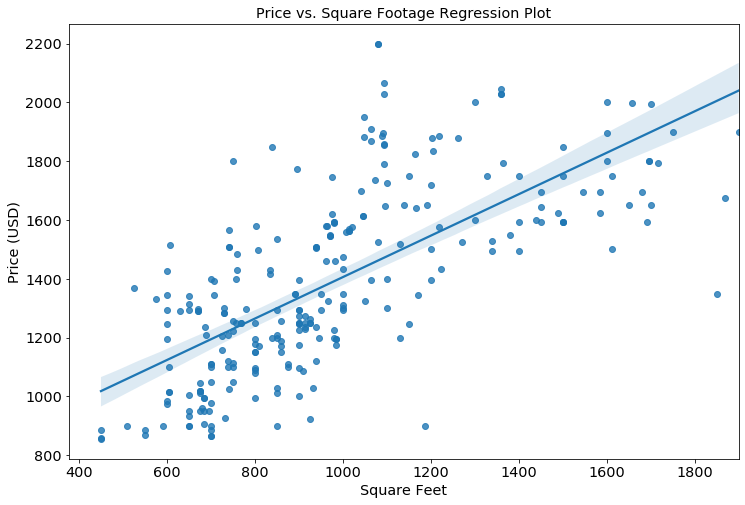

In [18]:
plt.figure(figsize=(12, 8))
sns.regplot(x='sqft', y='price', data=apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Square Feet");
plt.ylabel("Price (USD)");

In [19]:
apts.corr()

,number bedrooms,sqft,price,types,parking,laundry,medianIncome,medianHomeValue,postdateint,pYouths,pTwenties,pThirties,pForties,pFifties,pSixtyPlus
number bedrooms,1.000000,0.795476,0.498760,0.364464,0.080191,-0.011639,0.016990,0.017796,-0.010654,0.148657,-0.070364,-0.107101,0.001022,0.005545,-0.022853
sqft,0.795476,1.000000,0.599291,0.449321,-0.089656,-0.167874,0.151422,0.152351,-0.046200,0.094248,-0.143005,-0.105768,0.029218,0.042538,0.021079
price,0.498760,0.599291,1.000000,0.171925,-0.387563,-0.543582,0.081132,0.081429,0.044330,-0.148785,0.104018,0.083401,-0.013271,-0.020163,-0.023575
types,0.364464,0.449321,0.171925,1.000000,-0.035306,-0.112214,0.107883,0.107800,-0.057594,0.146405,-0.085448,-0.038212,0.091097,0.085227,0.007930
parking,0.080191,-0.089656,-0.387563,-0.035306,1.000000,0.605853,-0.186790,-0.186569,0.067199,0.200433,0.019286,-0.030523,-0.001453,-0.019053,-0.047768
laundry,-0.011639,-0.167874,-0.543582,-0.112214,0.605853,1.000000,-0.114973,-0.114767,-0.015770,0.147031,-0.076223,-0.081349,-0.023836,-0.021479,-0.000446
medianIncome,0.016990,0.151422,0.081132,0.107883,-0.186790,-0.114973,1.000000,1.000000,-0.161195,0.124167,-0.590209,-0.031462,0.712359,0.652333,0.293506
medianHomeValue,0.017796,0.152351,0.081429,0.107800,-0.186569,-0.114767,1.000000,1.000000,-0.160708,0.122602,-0.589761,-0.030335,0.714636,0.652992,0.292593
postdateint,-0.010654,-0.046200,0.044330,-0.057594,0.067199,-0.015770,-0.161195,-0.160708,1.000000,-0.056115,0.182108,0.110064,-0.024810,-0.046442,-0.038098
pYouths,0.148657,0.094248,-0.148785,0.146405,0.200433,0.147031,0.124167,0.122602,-0.056115,1.000000,0.157568,0.261032,0.616212,0.567155,0.388212


In [20]:
apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()

,number bedrooms,sqft,price,types,parking,laundry,medianIncome,medianHomeValue,postdateint,pYouths,pTwenties,pThirties,pForties,pFifties,pSixtyPlus
neighborhoods,,,,,,,,,,,,,,,
Anoka,1.0,735.0,1060.0,1.0,NaN,4.0,68130.0,68130.0,20200709.0,0.286762,0.125518,0.139239,0.163596,0.136952,0.147933
Apple Valley,1.0,857.0,1307.0,1.0,2.0,1.0,82990.0,82990.0,20200707.5,0.298739,0.111894,0.142556,0.167400,0.143295,0.136116
Aquila,1.0,750.0,1000.0,1.0,3.0,3.0,63699.0,63699.0,20200605.0,0.202044,0.191662,0.157827,0.128322,0.124875,0.195270
Armatage,1.0,1000.0,1500.0,1.0,3.0,1.0,92462.0,92462.0,20200725.0,0.244157,0.103516,0.156101,0.170372,0.159462,0.166391
Audubon Park,1.0,800.0,890.0,1.0,4.0,3.0,55486.0,55486.0,20200705.0,0.220141,0.160593,0.179391,0.140506,0.136061,0.163308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whittier,1.0,575.0,995.0,1.0,4.0,3.0,43178.0,43178.0,20200713.0,0.199403,0.292062,0.173902,0.114172,0.096235,0.104730
Willow Park,1.0,733.0,1555.0,1.0,2.0,1.0,63699.0,63699.0,20200630.0,0.202044,0.191662,0.157827,0.128322,0.124875,0.195270
Windom,1.0,650.0,885.0,1.0,4.0,3.0,94177.0,94177.0,20200715.0,0.261191,0.111149,0.157767,0.164319,0.148110,0.157464


In [21]:
#apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()['price'].sort_values()

In [22]:
#apts[apts['number bedrooms']<=brlim]['neighborhoods'].unique()

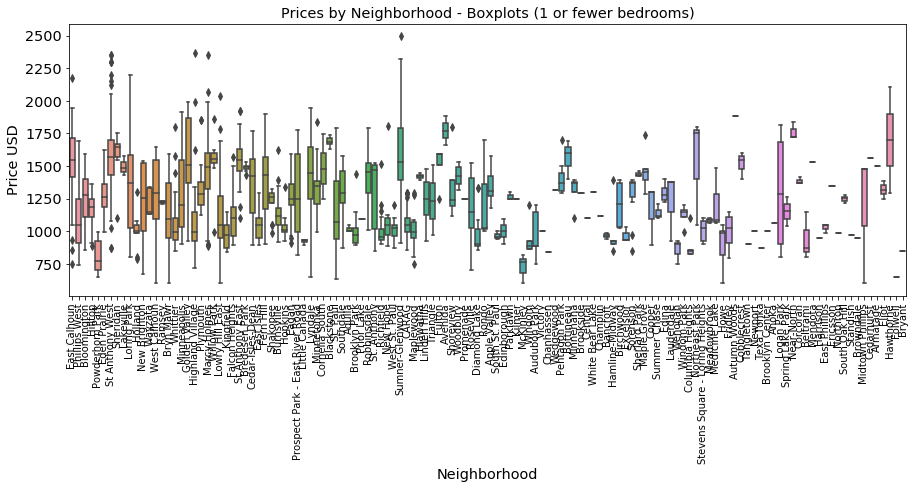

In [23]:
brlim = 1
sns.boxplot(x='neighborhoods', y='price', data=apts[apts['number bedrooms']<=brlim])
            #order=sorted(apts[apts['number bedrooms']<=brlim]['neighborhoods'].unique()))
plt.xlabel("Neighborhood");
plt.xticks(rotation=90,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots ("+str(brlim)+" or fewer bedrooms)");

In [25]:
#specify main columns of interest
maincols = ['number bedrooms',
            'sqft',
            'medianIncome',
            'pYouths',
            'pTwenties',
            'pThirties',
            'pForties',
            'pFifties',
            'pSixtyPlus',
            'postdateint']

# drop problematic 
apts = apts.dropna(subset=maincols+['cities','neighborhoods','types','laundry','parking'])

# recode neighborhoods
apts_onehot = apts.copy()
apts_onehot = pd.get_dummies(apts_onehot, columns=['cities'], prefix = ['ct'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['neighborhoods'], prefix = ['nb'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['types'], prefix = ['ty'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['laundry'], prefix = ['ld'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['parking'], prefix = ['pk'])
apts_onehot['parking'] = apts['parking']
apts_onehot['laundry'] = apts['laundry']
apts_onehot['cities'] = apts['cities']
apts_onehot['neighborhoods'] = apts['neighborhoods']

#print(apts_onehot)

In [26]:
from sklearn import preprocessing
from sklearn import linear_model

#nbcols = [col for col in apts_onehot if col.startswith('nb')]
#for c in nbcols:
#    maincols.append(c) 
#ctcols = [col for col in apts_onehot if col.startswith('ct')]
#for c in ctcols:
#    maincols.append(c) 
tycols = [col for col in apts_onehot if col.startswith('ty')]
for c in tycols:
    maincols.append(c) 
pkcols = [col for col in apts_onehot if col.startswith('pk')]
for c in pkcols:
    maincols.append(c) 
ldcols = [col for col in apts_onehot if col.startswith('ld')]
for c in ldcols:
    maincols.append(c) 

# set up regression
y = apts_onehot['price'].values.reshape(-1,1)
X = apts_onehot[maincols].values
thresh = .5 # drop columns that correlate above this value
cor = np.abs(np.corrcoef(X.T))
p = np.argwhere(np.triu(np.isclose(cor,1),1))
X = np.delete(X,p[:,1],axis=1)
Xavg = X.mean(axis=0)
Xstd = X.std(axis=0)
X = (X - Xavg) / Xstd
print("Number observations: "+str(X.shape[0]))

#OLS
reg = linear_model.LinearRegression()
reg.fit(y=y,X=X)
apts_onehot['price_est'] = np.zeros((apts_onehot.shape[0],1))
apts_onehot['price_est'] = reg.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100

# Ridge regression approach
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha': [.005, .01, .025, .05, .10, .5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=10)
ridge_regressor.fit(X=X,y=y)
print("Ridge params (best): "+str(ridge_regressor.best_params_))
print("Ridge score (best): "+str(ridge_regressor.best_score_))
apts_onehot['price_est'] = ridge_regressor.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100


Number observations: 3648
Ridge params (best): {'alpha': 64}
Ridge score (best): -46351.31131568726


In [27]:
#pd.options.display.max_colwidth = 200
#pd.options.display.max_rows = 600
#
#apts_onehot[(apts_onehot['price_difpct']<=10) & 
#            (apts_onehot['sqft']>=699) & 
#            (apts_onehot['price']<=1200) & 
#            (apts_onehot['number bedrooms']<=2)].sort_values('price_difpct',ascending=True)[['URL','price_difpct']] 

In [28]:
#Prepare data:
prices = np.array(apts_onehot['price'])
features = np.array(apts_onehot[maincols])
features = preprocessing.scale(features)
feature_list = list(apts_onehot[maincols])

In [29]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, prices, test_size = 0.20, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2918, 30)
Training Labels Shape: (2918,)
Testing Features Shape: (730, 30)
Testing Labels Shape: (730,)


In [30]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [31]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error: $', round(np.mean(errors), 2), '.')

Mean Absolute Error: $ 123.3 .


In [32]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 91.31 %.


In [33]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


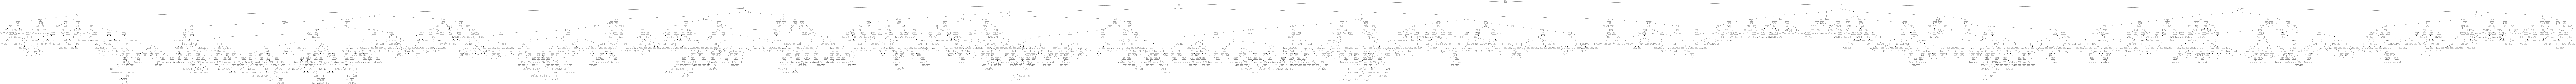

In [34]:
from IPython.display import Image 
Image("tree.png")

In [35]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sqft                 Importance: 0.48
Variable: ld_1.0               Importance: 0.21
Variable: pYouths              Importance: 0.06
Variable: number bedrooms      Importance: 0.05
Variable: postdateint          Importance: 0.05
Variable: pTwenties            Importance: 0.03
Variable: pThirties            Importance: 0.03
Variable: medianIncome         Importance: 0.02
Variable: pForties             Importance: 0.01
Variable: pFifties             Importance: 0.01
Variable: pSixtyPlus           Importance: 0.01
Variable: ty_1.0               Importance: 0.01
Variable: pk_1.0               Importance: 0.01
Variable: pk_2.0               Importance: 0.01
Variable: pk_4.0               Importance: 0.01
Variable: ty_2.0               Importance: 0.0
Variable: ty_3.0               Importance: 0.0
Variable: ty_4.0               Importance: 0.0
Variable: ty_5.0               Importance: 0.0
Variable: ty_6.0               Importance: 0.0
Variable: ty_8.0               Importance: 0.

In [36]:
print(apts_onehot['cities'].unique())

['Burnsville' 'Minneapolis' 'Bloomington' 'St. Paul' 'Hilltop' 'Maplewood'
 'Inver Grove Heights' 'Eden Prairie' 'Plymouth' 'Blaine' 'Chaska'
 'Lakeville' 'Woodbury' 'Minnetonka' 'New Brighton' 'Wayzata' 'Shoreview'
 'Ramsey' 'Robbinsdale' 'New Hope' 'Golden Valley' 'Saint Louis Park'
 'Edina' 'Falcon Heights' 'Hopkins' 'Shakopee' 'Little Canada' 'Eagan'
 'Richfield' 'Mounds View' 'North St. Paul' 'Grant' 'Brooklyn Park'
 'Roseville' 'Brooklyn Center' 'Savage' 'West St. Paul' 'Coon Rapids'
 'Maple Grove' 'St. Anthony' 'Chanhassen' 'Orono' 'Apple Valley'
 'South St. Paul' 'Anoka' 'Excelsior' 'Cottage Grove' 'Circle Pines'
 'Long Lake' 'Newport' 'Shorewood' 'Mendota' 'White Bear Lake' 'Hugo'
 'Fridley' 'Vadnais Heights' 'Oakdale' 'Lino Lakes' 'Lauderdale' 'Crystal'
 'Columbia Heights' 'Arden Hills' 'Prior Lake' 'Medicine Lake' 'Champlin'
 'Andover' 'Rosemount' 'Stillwater' 'Pine Springs' 'Lexington'
 'Spring Lake Park' 'St. Paul Park']


In [37]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 600

apts_onehot['price_est_rf'] = rf.predict(features)
apts_onehot['price_dif_rf'] = apts_onehot['price']-apts_onehot['price_est_rf']
apts_onehot['price_difpct_rf'] = (apts_onehot['price_dif_rf'] / apts_onehot['price_est_rf']) * 100
apts_onehot['price_difpct_avg'] = apts_onehot[['price_difpct','price_difpct_rf']].mean(axis=1)

apts_onehot[(apts_onehot['price_difpct_avg']<=15) & 
            (apts_onehot['parking'] <=4 ) &
            ((apts_onehot['laundry']==1) | (apts_onehot['laundry']==3) | (apts_onehot['laundry']==4)) & 
            (apts_onehot['sqft']>=599) & 
            (apts_onehot['price']<=1400) & 
            ((apts_onehot['cities']=='Minneapolis') | (apts_onehot['cities']=='Robbinsdale') |
             (apts_onehot['cities']=='Saint Louis Park') | (apts_onehot['cities']=='Richfield') |
             (apts_onehot['cities']=='St. Anthony') | (apts_onehot['cities']=='St. Paul')) &
            (apts_onehot.index>=np.round(np.percentile(apts_onehot.index,85)))].sort_values('posted',ascending=False)[['posted','neighborhoods','URL','price_difpct','price_difpct_rf','price_difpct_avg']] 

,posted,neighborhoods,URL,price_difpct,price_difpct_rf,price_difpct_avg
16712,2020-07-29 13:38:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/south-minneapolis-uptown-neighborhood/7154616119.html,-6.050683,-0.177850,-3.114266
16719,2020-07-29 13:30:00,Near-North,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-cute-2-bedroom-home-section/7168118249.html,18.433866,1.896117,10.164991
16727,2020-07-29 13:21:00,Highland Village,https://minneapolis.craigslist.org/ram/apa/d/saint-paul-excellent-location-in/7168111988.html,-1.368612,1.882933,0.257161
16753,2020-07-29 12:55:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-spacious-2-br-in-quiet-and/7166774370.html,0.446125,0.590999,0.518562
16578,2020-07-29 12:55:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-spacious-2-br-in-quiet-and/7166774370.html,0.446125,0.590999,0.518562
16762,2020-07-29 12:45:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-1-bedroom-apartment-in/7154616660.html,-9.633343,-0.906344,-5.269844
16769,2020-07-29 12:41:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-one-bedrooms-at-south-mpls/7154615803.html,-9.779538,-0.538260,-5.158899
16770,2020-07-29 12:39:00,Diamond Lake,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-tranquil-locaton-across/7168038408.html,-4.380393,3.833175,-0.273609
16775,2020-07-29 12:34:00,St. Anthony,https://minneapolis.craigslist.org/ram/apa/d/minneapolis-large-updated-one-bedroom/7156477446.html,4.855087,-1.443680,1.705703
16784,2020-07-29 12:29:00,Audubon Park,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-lovely-2-br-duplexpvt/7168074699.html,-16.865649,-6.696365,-11.781007


In [38]:
newZipCode = 55406                 #int
newSqFt = 799.                     #float
numBeds = 1.                       #float
postDateInt = 20200627             #int
typeListing = 'apartment'          #'apartment','condo','cottage/cabin','duplex','flat','house','in-law','loft','townhouse','manufactured','assisted living','land'
typeLaundry = 'laundry in bldg'    #'w/d in unit','w/d hookups','laundry in bldg','laundry on site','no laundry on site'
typeParking = 'off-street parking' #'carport','attached garage','detached garage','off-street parking','street parking','valet parking','no parking'

In [39]:
zipcode = search.by_zipcode(newZipCode)
zipDict = zipcode.to_dict()
income = zipDict['median_household_income']
popsByAge = list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] ))
popsByAge = np.array(popsByAge) / zipDict['population']
pYouths = popsByAge[0:3].sum()
pTwenties = popsByAge[4:5].sum()
pThirties = popsByAge[6:7].sum()
pForties = popsByAge[8:9].sum()
pFifties = popsByAge[10:11].sum()
pSixtyPlus = popsByAge[12:17].sum()


In [40]:
#append a new data frame to the old one including 
newApt = pd.DataFrame({
    'zipcode':[newZipCode],
    'sqft':[newSqFt],
    'number bedrooms':[numBeds],
    'postdateint':[postDateInt],
    'types':[np.float(TypeDict[typeListing])],
    'parking':[np.float(ParkingDict[typeParking])],
    'laundry':[np.float(LaundryDict[typeLaundry])],
    'medianIncome':[income],
    'pYouths':[pYouths],
    'pTwenties':[pTwenties],
    'pThirties':[pThirties],
    'pForties':[pForties],
    'pFifties':[pFifties],
    'pSixtyPlus':[pSixtyPlus]})
newApt_onehot = newApt
newApt_onehot = pd.get_dummies(newApt_onehot, columns=['types'], prefix = ['ty'])
newApt_onehot = pd.get_dummies(newApt_onehot, columns=['laundry'], prefix = ['ld'])
newApt_onehot = pd.get_dummies(newApt_onehot, columns=['parking'], prefix = ['pk'])
print(newApt_onehot)


   zipcode   sqft  number bedrooms  postdateint  medianIncome   pYouths  \
0    55406  799.0              1.0     20200627         56989  0.162058   

   pTwenties  pThirties  pForties  pFifties  pSixtyPlus  ty_1.0  ld_3.0  \
0   0.059791   0.095073  0.071406  0.080126    0.141785       1       1   

   pk_4.0  
0       1  


In [41]:
apts_onehot = apts_onehot.append(newApt_onehot,ignore_index=True)


In [42]:
new_features = apts_onehot.iloc[[-1,]].fillna(0.)[maincols].values
new_features = (new_features - Xavg) / Xstd
print('Ridge prediction: $'+str(int(ridge_regressor.predict(new_features)[0])))
print('Random forest prediction: $'+str(int(rf.predict(new_features)[0])))

Ridge prediction: $1106
Random forest prediction: $1189
